# Adversarial Validation - train/test distribution mismatch identification

Sources: <br>
http://fastml.com/adversarial-validation/ <br>
http://fastml.com/adversarial-validation-part-two/

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

#### I'll be using a dataset from Numerai (2018-04-15)
#### Binary classification prediction on encrypted data

In [4]:
training_data = pd.read_csv('./numerai_datasets_15_04_2018/numerai_training_data.csv', header=0)
prediction_data = pd.read_csv('./numerai_datasets_15_04_2018/numerai_tournament_data.csv', header=0)

In [21]:
print("Train dataset size: "+str(training_data.shape))
print("Validation/Test dataset size: "+str(prediction_data.shape))

Train dataset size: (393613, 54)
Validation/Test dataset size: (243377, 54)


In [5]:
training_data.head()

,id,era,data_type,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,target
0,n2b2e3dd163cb422,era1,train,0.43487,0.44645,0.25802,0.37149,0.62235,0.67451,0.68103,...,0.52962,0.42439,0.51680,0.46297,0.57426,0.57946,0.49646,0.48968,0.54194,1
1,n177021a571c94c8,era1,train,0.50038,0.39216,0.38394,0.51213,0.36660,0.46911,0.68204,...,0.51669,0.48445,0.57587,0.59860,0.67558,0.45577,0.80908,0.50287,0.61629,0
2,n7830fa4c0cd8466,era1,train,0.47416,0.34143,0.39528,0.46337,0.72953,0.45962,0.47869,...,0.41458,0.34804,0.29058,0.51382,0.36389,0.80602,0.39253,0.41821,0.58679,0
3,nc594a184cee941b,era1,train,0.48759,0.55903,0.43987,0.38834,0.44650,0.46389,0.70749,...,0.28776,0.42881,0.55402,0.53695,0.48793,0.62432,0.52898,0.49009,0.49557,0
4,nc5ab8667901946a,era1,train,0.23433,0.55499,0.47849,0.56990,0.64945,0.47152,0.62085,...,0.64405,0.32416,0.33193,0.58065,0.44587,0.47770,0.44020,0.47895,0.57978,0


In [6]:
# identify features
features = [f for f in list(training_data) if "feature" in f]

#### Split between train, validation and test dataset

In [8]:
# Train dataset
X_train = training_data[features+["target", "id"]]

# Validation dataset
X_val = prediction_data[prediction_data["target"].notnull()][features+["target", "id"]]

# Test dataset
X_test = prediction_data[prediction_data["target"].isnull()][features+["target", "id"]]

x_prediction = prediction_data[features]
ids = prediction_data["id"]

#### Prepare datasets for training

In [9]:
X_train_check = X_train.copy()
X_test_check = X_test.copy()

# Mark train obserations as 1 and test observations as 0
X_train_check['TARGET_adv'] = 0
X_test_check['TARGET_adv'] = 1

# Concatenate train and test datasets into one dataset
adv_val_set = pd.concat(( X_train_check, X_test_check ))
adv_val_set.reset_index( inplace = True, drop = True )

# Split features and target
adv_val_x = adv_val_set.drop(["TARGET_adv", "target"], axis=1)
adv_val_y = adv_val_set.TARGET_adv 

#### Predict observations to be train or test

In [13]:
# Instantiate classifier
adv_val_clf = RandomForestClassifier( n_estimators=50, n_jobs = -1, random_state=55555 )

# setup stratified k-fold cross-validation
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 55555 )

# Predict (prediction based on model built when observation was in cv test set)
predictions = cross_val_predict(adv_val_clf, X=adv_val_x.drop("id", axis=1), y=adv_val_y, 
                          cv=skf, n_jobs=-1, method='predict_proba')

#### Check model performance based on AUC

In [14]:
roc_auc_score( adv_val_y, predictions[:, 1] )

0.7723257652102933

An AUC of 77% means the model was able to distinguish between the train and test datasets. <br>
This means our train and test datasets have different distributions. <br>
Let's identify 


#### Sort the training points by their estimated probability of being test examples

In [17]:
# Get adversarial prediction into the adversarial dataset
adv_val_set['adversarial_pred'] = predictions[:, 1]

# Get only train observations
adv_val_set_sorted = adv_val_set[adv_val_set["TARGET_adv"] == 0]

# Sort observations by the adversarial prediction
adv_val_set_sorted = adv_val_set_sorted.sort_values(by="adversarial_pred")

#### Inspect top and end observations, and the probability of being a test example distribution (after sorting)

In [27]:
adv_val_set_sorted[["id","TARGET_adv","adversarial_pred"]].head(3)

,id,TARGET_adv,adversarial_pred
222789,n0ffbac15127e471,0,0.00
93003,n9b933ecfee6e451,0,0.02
313886,n25441ee5fdb846f,0,0.02


In [28]:
adv_val_set_sorted[["id","TARGET_adv","adversarial_pred"]].tail(3)

,id,TARGET_adv,adversarial_pred
314247,n07cf252d738245c,0,0.76
99166,n56462a4db86742d,0,0.78
103647,nbdc94a0b1c0a483,0,0.80


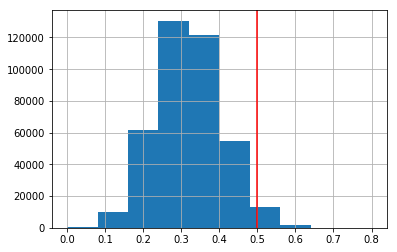

In [37]:
adv_val_set_sorted.adversarial_pred.hist()
plt.axvline(x=0.5, color="red")
plt.show()

In [42]:
print(adv_val_set_sorted[adv_val_set_sorted.adversarial_pred > 0.5].shape[0])
print(adv_val_set_sorted[adv_val_set_sorted.adversarial_pred > 0.5].shape[0] / adv_val_set_sorted.shape[0])

6154
0.015634646213412668


Numerai is a highly noisy dataset, and because of that only 6154 observations (15%) get a probability of being a test example of more than 50%

#### Take the desired number of examples from the end (higher probability of being a test set observation) and use those as the new training

In [43]:
val_size = 50000

# New train and validation sets
new_train_set = adv_val_set_sorted.iloc[:-val_size].drop(["TARGET_adv", "adversarial_pred"], axis=1)
new_val_set = adv_val_set_sorted.iloc[-val_size:].drop(["TARGET_adv", "adversarial_pred"], axis=1)